<a href="https://colab.research.google.com/github/data-science-and-machine-learning/CNN-MNIST/blob/master/CNN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Credits: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py


from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import backend as K
import numpy as np

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

def plt_dynamic(x, vy, ty, colors=['b']):
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch')
    ax.set_ylabel('Categorical Crossentropy Loss')
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()


Using TensorFlow backend.


11493376/11490434 [==============================] - 2s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [24]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 20s 341us/step - loss: 0.2944 - acc: 0.9102 - val_loss: 0.0642 - val_acc: 0.9801
Epoch 2/12
60000/60000 [==============================] - 10s 164us/step - loss: 0.0927 - acc: 0.9719 - val_loss: 0.0442 - val_acc: 0.9852
Epoch 3/12
60000/60000 [==============================] - 10s 164us/step - loss: 0.0700 - acc: 0.9791 - val_loss: 0.0356 - val_acc: 0.9879
Epoch 4/12
60000/60000 [==============================] - 10s 165us/step - loss: 0.0554 - acc: 0.9833 - val_loss: 0.0293 - val_acc: 0.9904
Epoch 5/12
60000/60000 [==============================] - 10s 164us/step - loss: 0.0477 - acc: 0.9854 - val_loss: 0.0301 - val_acc: 0.9900
Epoch 6/12
60000/60000 [==============================] - 10s 166us/step - loss: 0.0434 - acc: 0.9868 - val_loss: 0.0307 - val_acc: 0.9906
Epoch 7/12
60000/60000 [==============================] - 10s 165us/step - loss: 0.0398 - acc: 0.9880 - val_loss: 0.

## Model 1 : Hyperparameter tuning on kernel size, applying cross validation and comparing results

In [25]:
def conv_model(kernel):
  model_1 = Sequential()
  #Layer 1 [ReLU]
  model_1.add(Conv2D(32, kernel_size=kernel,
                  activation='relu',
                  input_shape=input_shape))

  #Layer 2 [ReLU]
  model_1.add(Conv2D(64, kernel, activation='relu'))
  model_1.add(MaxPooling2D(pool_size=(2, 2)))
  model_1.add(Dropout(0.25))

  #Layer 3 [ReLU]
  model_1.add(Flatten())
  model_1.add(Dense(128, activation='relu'))
  model_1.add(Dropout(0.5))

  #Layer 4 [Softmax]
  model_1.add(Dense(num_classes, activation='softmax'))

  model_1.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.Adadelta(),
                metrics=['accuracy'])
  return model_1


from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, ShuffleSplit

model = KerasClassifier(build_fn=conv_model, epochs=20, verbose=0)

batch = [32, 64, 128]
param_grid = dict(batch_size=batch,\
                  kernel= [(3,3), (5,5), (7,7)]
                  )

grid = GridSearchCV(estimator= model, param_grid= param_grid, cv= 2, return_train_score= True, verbose= 1)
grid_result_kernel_hptuning= grid.fit(x_train, y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 51.6min finished


In [30]:
print("Best: %f using %s" % (grid_result_kernel_hptuning.best_score_, grid_result_kernel_hptuning.best_params_))
print("Best estimator: ", grid_result_kernel_hptuning.best_estimator_)

means_test = grid_result_kernel_hptuning.cv_results_['mean_test_score']
means_train = grid_result_kernel_hptuning.cv_results_['mean_train_score']
stds_test = grid_result_kernel_hptuning.cv_results_['std_test_score']
stds_train = grid_result_kernel_hptuning.cv_results_['std_train_score']
params = grid_result_kernel_hptuning.cv_results_['params']

for mean, mean_train, stdev, param in zip(means_test, means_train, stds_test, params):
    print("%f %f (%f) with: %r" % (mean, mean_train, stdev, param))

Best: 0.991367 using {'batch_size': 64, 'kernel': (7, 7)}
Best estimator:  <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f5a831fde80>
0.987983 0.998283 (0.000383) with: {'batch_size': 32, 'kernel': (3, 3)}
0.989783 0.999250 (0.000250) with: {'batch_size': 32, 'kernel': (5, 5)}
0.990533 0.999533 (0.001067) with: {'batch_size': 32, 'kernel': (7, 7)}
0.988783 0.999150 (0.000383) with: {'batch_size': 64, 'kernel': (3, 3)}
0.990667 0.999333 (0.000300) with: {'batch_size': 64, 'kernel': (5, 5)}
0.991367 0.999633 (0.000100) with: {'batch_size': 64, 'kernel': (7, 7)}
0.989117 0.999317 (0.000783) with: {'batch_size': 128, 'kernel': (3, 3)}
0.990117 0.999167 (0.000050) with: {'batch_size': 128, 'kernel': (5, 5)}
0.990700 0.999300 (0.000800) with: {'batch_size': 128, 'kernel': (7, 7)}


In [27]:
import pickle
with open('grid_result_kernel_hptuning_cv_results.pickle', 'wb') as handle:
    pickle.dump(grid_result_kernel_hptuning.cv_results_, handle, protocol=pickle.HIGHEST_PROTOCOL)
!cp grid_result_kernel_hptuning.pickle drive/My\ Drive/CNN_models/

cp: cannot stat 'grid_result_kernel_hptuning.pickle': No such file or directory


9


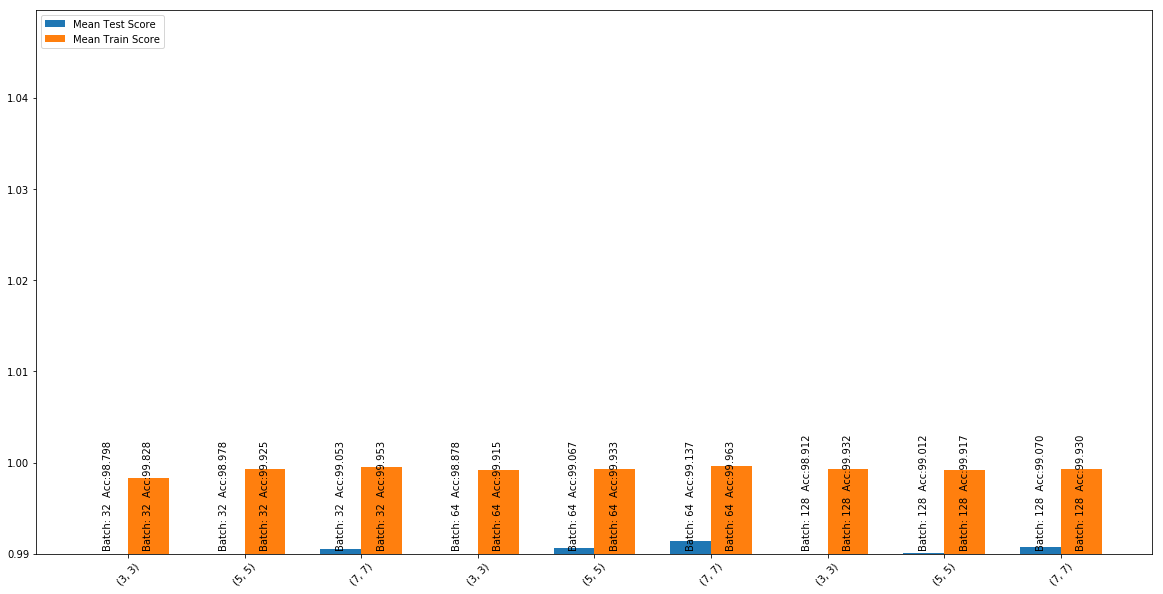

In [28]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(20,10))

ind= np.arange(len(params))
width= 0.35
print(len(params))

rects1 = ax.bar(ind - width/2, means_test, width, 
                label='Mean Test Score')
rects2 = ax.bar(ind + width/2, means_train, width, 
                label='Mean Train Score')

ax.set_xticks(ind)
ax.set_xticklabels([param['kernel'] for param in params], rotation=45)
batches= [param['batch_size'] for param in params]

i= 0
for rect in rects1:
    ax.annotate('Batch: {}  Acc:{:.3f}'.format(batches[i], means_test[i]*100), rotation=90,
                xy=(rect.get_x() + rect.get_width() / 2, 0.99),
                xytext=(0, 3),  # use 3 points offset
                textcoords="offset points",  # in both directions
                ha='center', va='bottom',
                horizontalalignment='center', verticalalignment='center_baseline')
    i+=1
i=0
for rect in rects2:
    ax.annotate('Batch: {}  Acc:{:.3f}'.format(batches[i], means_train[i]*100), rotation=90,
                xy=(rect.get_x() + rect.get_width() / 2, 0.99),
                xytext=(0, 3),  # use 3 points offset
                textcoords="offset points",  # in both directions
                ha='center', va='bottom')
    i+=1
ax.set_ylim(bottom=0.99)
ax.legend(loc= 'upper left')

It can be observed (7, 7) kernel improved test result and best among all with 64 batch size

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 39s 654us/step - loss: 0.1753 - acc: 0.9466 - val_loss: 0.0418 - val_acc: 0.9860
Epoch 2/20
60000/60000 [==============================] - 26s 434us/step - loss: 0.0688 - acc: 0.9798 - val_loss: 0.0273 - val_acc: 0.9914
Epoch 3/20
60000/60000 [==============================] - 26s 434us/step - loss: 0.0508 - acc: 0.9850 - val_loss: 0.0259 - val_acc: 0.9916
Epoch 4/20
60000/60000 [==============================] - 26s 434us/step - loss: 0.0413 - acc: 0.9879 - val_loss: 0.0275 - val_acc: 0.9913
Epoch 5/20
60000/60000 [==============================] - 26s 433us/step - loss: 0.0376 - acc: 0.9889 - val_loss: 0.0238 - val_acc: 0.9926
Epoch 6/20
60000/60000 [==============================] - 26s 433us/step - loss: 0.0345 - acc: 0.9893 - val_loss: 0.0237 - val_acc: 0.9930
Epoch 7/20
60000/60000 [==============================] - 26s 433us/step - loss: 0.0307 - acc: 0.9906 - val_loss: 0.

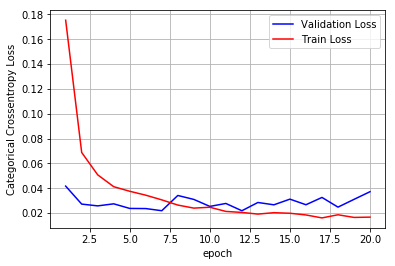

In [29]:
# best model
model= conv_model((7, 7))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

history= model.fit(x_train, y_train,
          batch_size=32,
          epochs=20,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x = list(range(1,21))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, 1)

## Model 2 : Hyperparameter tuning with added Batch normalization, applying cross validation and comparing results

In [31]:
# Adding batch normalization to the model
def conv_model(kernel):
  Model_2= Sequential()
  #Layer 1 [ReLU]
  Model_2.add(Conv2D(32, kernel_size=kernel,
                  activation='relu',
                  input_shape=input_shape))
  Model_2.add(BatchNormalization())

  #Layer 2 [ReLU]
  Model_2.add(Conv2D(64, kernel, activation='relu'))
  Model_2.add(BatchNormalization())
  Model_2.add(MaxPooling2D(pool_size=(2, 2)))
  Model_2.add(Dropout(0.25))

  #Layer 3 [ReLU]
  Model_2.add(Flatten())
  Model_2.add(Dense(128, activation='relu'))
  Model_2.add(BatchNormalization())
  Model_2.add(Dropout(0.5))

  #Layer 4 [Softmax]
  Model_2.add(Dense(num_classes, activation='softmax'))

  Model_2.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.Adadelta(),
                metrics=['accuracy'])
  return Model_2


from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, ShuffleSplit

model = KerasClassifier(build_fn=conv_model, epochs=20, verbose=0)

batch = [32, 64, 128]
param_grid = dict(batch_size=batch,\
                  kernel= [(3,3), (5,5), (7,7)]
                  )

grid = GridSearchCV(estimator= model, param_grid= param_grid, cv= 2, return_train_score= True, verbose= 1)
grid_result_batchnorm= grid.fit(x_train, y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 70.2min finished


In [32]:
print("Best: %f using %s" % (grid_result_batchnorm.best_score_, grid_result_batchnorm.best_params_))
print("Best estimator: ", grid_result_batchnorm.best_estimator_)

means_test = grid_result_batchnorm.cv_results_['mean_test_score']
means_train = grid_result_batchnorm.cv_results_['mean_train_score']
stds_test = grid_result_batchnorm.cv_results_['std_test_score']
stds_train = grid_result_batchnorm.cv_results_['std_train_score']
params = grid_result_batchnorm.cv_results_['params']

for mean, mean_train, stdev, param in zip(means_test, means_train, stds_test, params):
    print("%f %f (%f) with: %r" % (mean, mean_train, stdev, param))

Best: 0.991050 using {'batch_size': 128, 'kernel': (7, 7)}
Best estimator:  <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f5a7387f978>
0.989033 0.999850 (0.000200) with: {'batch_size': 32, 'kernel': (3, 3)}
0.990767 0.999917 (0.000300) with: {'batch_size': 32, 'kernel': (5, 5)}
0.990183 0.999733 (0.001517) with: {'batch_size': 32, 'kernel': (7, 7)}
0.988533 0.999900 (0.000633) with: {'batch_size': 64, 'kernel': (3, 3)}
0.991000 0.999917 (0.000067) with: {'batch_size': 64, 'kernel': (5, 5)}
0.990750 0.999833 (0.000150) with: {'batch_size': 64, 'kernel': (7, 7)}
0.987950 0.999933 (0.000317) with: {'batch_size': 128, 'kernel': (3, 3)}
0.989833 0.999767 (0.000167) with: {'batch_size': 128, 'kernel': (5, 5)}
0.991050 0.999850 (0.000550) with: {'batch_size': 128, 'kernel': (7, 7)}


In [33]:
import pickle
with open('grid_result_batchnorm_cv_results.pickle', 'wb') as handle:
    pickle.dump(grid_result_batchnorm.cv_results_, handle, protocol=pickle.HIGHEST_PROTOCOL)
!cp grid_result_batchnorm.pickle drive/My\ Drive/CNN_models/

cp: cannot stat 'grid_result_batchnorm.pickle': No such file or directory


9


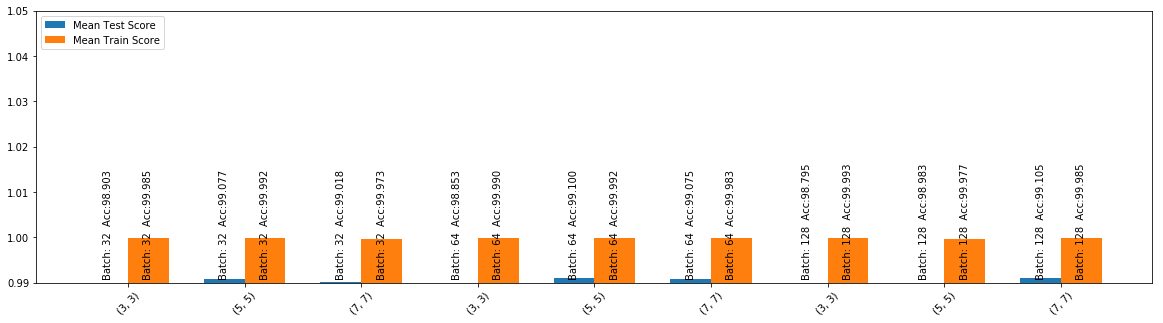

In [34]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(20,5))

ind= np.arange(len(params))
width= 0.35
print(len(params))

rects1 = ax.bar(ind - width/2, means_test, width, 
                label='Mean Test Score')
rects2 = ax.bar(ind + width/2, means_train, width, 
                label='Mean Train Score')

ax.set_xticks(ind)
ax.set_xticklabels([param['kernel'] for param in params], rotation=45)
batches= [param['batch_size'] for param in params]

i= 0
for rect in rects1:
    ax.annotate('Batch: {}  Acc:{:.3f}'.format(batches[i], means_test[i]*100), rotation=90,
                xy=(rect.get_x() + rect.get_width() / 2, 0.99),
                xytext=(0, 3),  # use 3 points offset
                textcoords="offset points",  # in both directions
                ha='center', va='bottom',
                horizontalalignment='center', verticalalignment='center_baseline')
    i+=1
i=0
for rect in rects2:
    ax.annotate('Batch: {}  Acc:{:.3f}'.format(batches[i], means_train[i]*100), rotation=90,
                xy=(rect.get_x() + rect.get_width() / 2, 0.99),
                xytext=(0, 3),  # use 3 points offset
                textcoords="offset points",  # in both directions
                ha='center', va='bottom')
    i+=1
ax.set_ylim(bottom=0.99)
ax.legend(loc= 'upper left')

After applying batch normalization we can see 2 more models predicting more than 99% accuracy, also the best accuracy is 99.14 which is an improvement. Hence batch normalization is useful.

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 52s 867us/step - loss: 0.1491 - acc: 0.9549 - val_loss: 0.0414 - val_acc: 0.9860
Epoch 2/20
60000/60000 [==============================] - 34s 572us/step - loss: 0.0647 - acc: 0.9802 - val_loss: 0.0257 - val_acc: 0.9914
Epoch 3/20
60000/60000 [==============================] - 35s 577us/step - loss: 0.0491 - acc: 0.9852 - val_loss: 0.0343 - val_acc: 0.9885
Epoch 4/20
60000/60000 [==============================] - 34s 572us/step - loss: 0.0447 - acc: 0.9867 - val_loss: 0.0232 - val_acc: 0.9918
Epoch 5/20
60000/60000 [==============================] - 34s 571us/step - loss: 0.0368 - acc: 0.9887 - val_loss: 0.0295 - val_acc: 0.9902
Epoch 6/20
60000/60000 [==============================] - 34s 570us/step - loss: 0.0306 - acc: 0.9908 - val_loss: 0.0168 - val_acc: 0.9945
Epoch 7/20
60000/60000 [==============================] - 34s 573us/step - loss: 0.0282 - acc: 0.9913 - val_loss: 0.

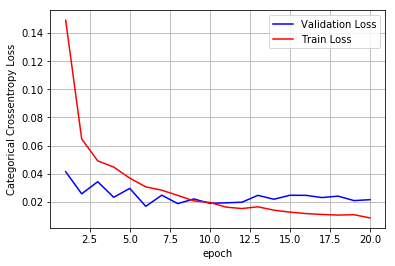

In [35]:
# best model
model= conv_model((7, 7))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

history= model.fit(x_train, y_train,
          batch_size=32,
          epochs=20,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x = list(range(1,21))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, 1)

## Model 3 : Hyperparameter tuning with varying kernels, applying cross validation and comparing results

In [2]:
# Adding batch normalization to the model
def conv_model_varying_kernel(kernel_n):
  Model_3 = Sequential()
  #Layer 1 [ReLU]
  Model_3.add(Conv2D(32, kernel_size=(kernel_n, kernel_n),
                  activation='relu',
                  input_shape=input_shape))
  Model_3.add(BatchNormalization())

  #Layer 2 [ReLU]
  Model_3.add(Conv2D(64, (kernel_n+2, kernel_n+2), activation='relu'))
  Model_3.add(BatchNormalization())
  Model_3.add(MaxPooling2D(pool_size=(2, 2)))
  Model_3.add(Dropout(0.25))

  #Layer 3 [ReLU]
  Model_3.add(Flatten())
  Model_3.add(Dense(128, activation='relu'))
  Model_3.add(BatchNormalization())
  Model_3.add(Dropout(0.5))

  #Layer 4 [Softmax]
  Model_3.add(Dense(num_classes, activation='softmax'))

  Model_3.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.Adadelta(),
                metrics=['accuracy'])
  return Model_3


from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, ShuffleSplit

model = KerasClassifier(build_fn=conv_model_varying_kernel, epochs=20, verbose=0)

batch = [32, 64, 128]
param_grid = dict(batch_size=batch,\
                  kernel_n= [3, 5, 7]
                  )

grid = GridSearchCV(estimator= model, param_grid= param_grid, cv= 2, return_train_score= True, verbose= 1)
grid_result_varyingkernel= grid.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
W0819 02:19:09.553673 140023347165056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0819 02:19:09.599063 140023347165056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0819 02:19:09.605800 140023347165056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



Fitting 2 folds for each of 9 candidates, totalling 18 fits


W0819 02:19:09.654608 140023347165056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0819 02:19:09.655855 140023347165056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0819 02:19:12.576645 140023347165056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0819 02:19:12.762494 140023347165056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0819 02:19:12.772203 14002334

In [3]:
print("Best: %f using %s" % (grid_result_varyingkernel.best_score_, grid_result_varyingkernel.best_params_))
print("Best estimator: ", grid_result_varyingkernel.best_estimator_)

means_test = grid_result_varyingkernel.cv_results_['mean_test_score']
means_train = grid_result_varyingkernel.cv_results_['mean_train_score']
stds_test = grid_result_varyingkernel.cv_results_['std_test_score']
stds_train = grid_result_varyingkernel.cv_results_['std_train_score']
params = grid_result_varyingkernel.cv_results_['params']

for mean, mean_train, stdev, param in zip(means_test, means_train, stds_test, params):
    print("%f %f (%f) with: %r" % (mean, mean_train, stdev, param))

Best: 0.991433 using {'batch_size': 64, 'kernel_n': 7}
Best estimator:  <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f596f036080>
0.990133 0.999950 (0.000267) with: {'batch_size': 32, 'kernel_n': 3}
0.991200 0.999900 (0.000700) with: {'batch_size': 32, 'kernel_n': 5}
0.991033 0.999867 (0.000100) with: {'batch_size': 32, 'kernel_n': 7}
0.990250 0.999933 (0.000317) with: {'batch_size': 64, 'kernel_n': 3}
0.990133 0.999583 (0.000667) with: {'batch_size': 64, 'kernel_n': 5}
0.991433 1.000000 (0.000267) with: {'batch_size': 64, 'kernel_n': 7}
0.990133 0.999967 (0.000333) with: {'batch_size': 128, 'kernel_n': 3}
0.990817 0.999950 (0.000617) with: {'batch_size': 128, 'kernel_n': 5}
0.990850 1.000000 (0.000617) with: {'batch_size': 128, 'kernel_n': 7}


In [4]:
import pickle
with open('grid_result_varyingkernel.pickle', 'wb') as handle:
    pickle.dump(grid_result_varyingkernel.cv_results_, handle, protocol=pickle.HIGHEST_PROTOCOL)
!cp grid_result_varyingkernel.pickle drive/My\ Drive/CNN_models/

cp: cannot create regular file 'drive/My Drive/CNN_models/': No such file or directory


9


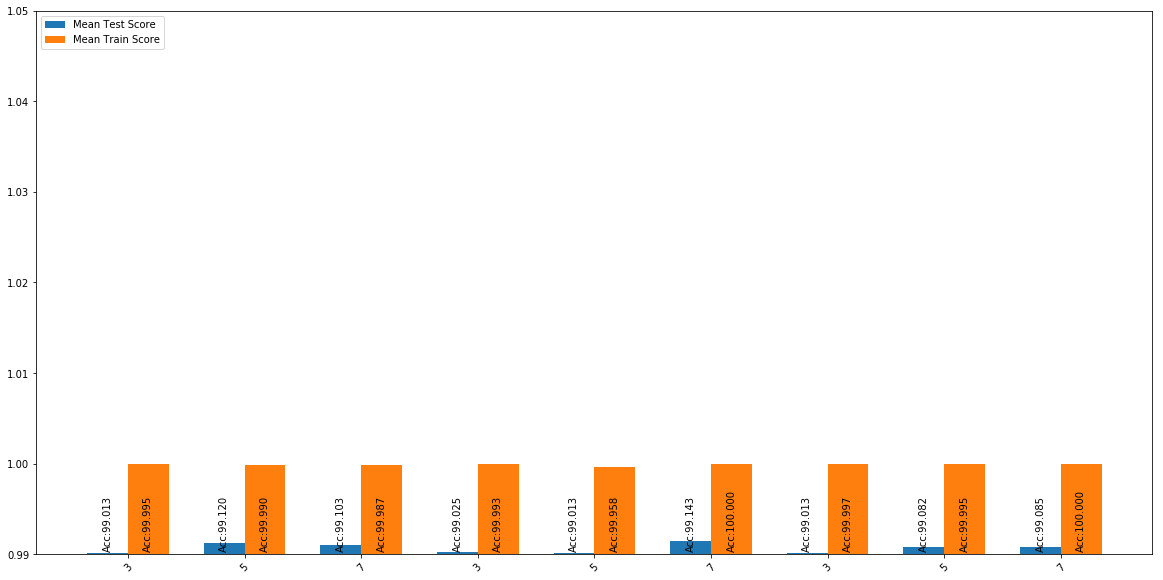

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,10))

ind= np.arange(len(params))
width= 0.35
print(len(params))

rects1 = ax.bar(ind - width/2, means_test, width, 
                label='Mean Test Score')
rects2 = ax.bar(ind + width/2, means_train, width, 
                label='Mean Train Score')

ax.set_xticks(ind)
ax.set_xticklabels([param['kernel_n'] for param in params], rotation=45)
batches= [param['batch_size'] for param in params]

i= 0
for rect in rects1:
    ax.annotate('Acc:{:.3f}'.format(means_test[i]*100), rotation=90,
                xy=(rect.get_x() + rect.get_width() / 2, 0.99),
                xytext=(0, 3),  # use 3 points offset
                textcoords="offset points",  # in both directions
                ha='center', va='bottom',
                horizontalalignment='center', verticalalignment='center_baseline')
    i+=1
i=0
for rect in rects2:
    ax.annotate('Acc:{:.3f}'.format(means_train[i]*100), rotation=90,
                xy=(rect.get_x() + rect.get_width() / 2, 0.99),
                xytext=(0, 3),  # use 3 points offset
                textcoords="offset points",  # in both directions
                ha='center', va='bottom')
    i+=1
ax.set_ylim(bottom=0.99)
ax.legend(loc= 'upper left')

Significant improvement can be seen using increasing kernels: This is because small kernels are taking care of smaller details while bigger kernels are looking at larger pictures of features.

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 21s 358us/step - loss: 0.1561 - acc: 0.9519 - val_loss: 0.0460 - val_acc: 0.9851
Epoch 2/20
60000/60000 [==============================] - 17s 278us/step - loss: 0.0560 - acc: 0.9830 - val_loss: 0.0308 - val_acc: 0.9906
Epoch 3/20
60000/60000 [==============================] - 16s 275us/step - loss: 0.0433 - acc: 0.9870 - val_loss: 0.0319 - val_acc: 0.9888
Epoch 4/20
60000/60000 [==============================] - 16s 271us/step - loss: 0.0351 - acc: 0.9895 - val_loss: 0.0257 - val_acc: 0.9915
Epoch 5/20
60000/60000 [==============================] - 16s 270us/step - loss: 0.0301 - acc: 0.9903 - val_loss: 0.0247 - val_acc: 0.9916
Epoch 6/20
60000/60000 [==============================] - 16s 269us/step - loss: 0.0267 - acc: 0.9915 - val_loss: 0.0242 - val_acc: 0.9925
Epoch 7/20
60000/60000 [==============================] - 16s 269us/step - loss: 0.0220 - acc: 0.9932 - val_loss: 0.

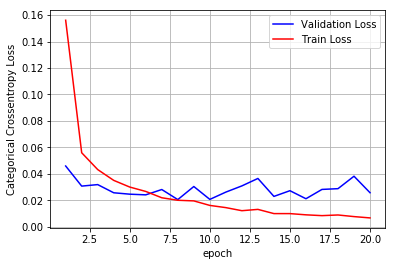

In [7]:
# Best model
model= conv_model_varying_kernel(7)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

history= model.fit(x_train, y_train,
          batch_size=64,
          epochs=20,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x = list(range(1,21))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, 1)

## Model 4 : Hyperparameter tuning with 5 layers, batch normalization and varying kernels, applying cross validation and comparing results

In [8]:
# Adding batch normalization to the model
def conv_model_varying_kernel(kernel_n):
  Model_4 = Sequential()
  #Layer 1 [ReLU]
  Model_4.add(Conv2D(32, kernel_size=(kernel_n, kernel_n),
                  activation='relu',
                  input_shape=input_shape, padding='same'))
  Model_4.add(BatchNormalization())

  #Layer 2 [ReLU]
  Model_4.add(Conv2D(64, (kernel_n+2, kernel_n+2), activation='relu', padding='same'))
  Model_4.add(BatchNormalization())
  Model_4.add(MaxPooling2D(pool_size=(2, 2)))
  Model_4.add(Dropout(0.25))

  #Layer 3 [ReLU]
  Model_4.add(Conv2D(128, (kernel_n+4, kernel_n+4), activation='relu', padding='same'))
  Model_4.add(BatchNormalization())
  Model_4.add(MaxPooling2D(pool_size=(2, 2)))
  Model_4.add(Dropout(0.25))

  #Layer 4 [ReLU]
  Model_4.add(Flatten())
  Model_4.add(Dense(256, activation='relu'))
  Model_4.add(BatchNormalization())
  Model_4.add(Dropout(0.5))

  #Layer 5 [Softmax]
  Model_4.add(Dense(num_classes, activation='softmax'))

  Model_4.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.Adadelta(),
                metrics=['accuracy'])
  return Model_4


from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, ShuffleSplit

model = KerasClassifier(build_fn=conv_model_varying_kernel, epochs=20, verbose=0)

batch = [32, 64, 128]
param_grid = dict(batch_size=batch,\
                  kernel_n= [3, 5, 7]
                  )

grid = GridSearchCV(estimator= model, param_grid= param_grid, cv= 2, return_train_score= True, verbose= 1)
grid_result_varyingkernel= grid.fit(x_train, y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 115.7min finished


In [9]:
print(input_shape)

(28, 28, 1)


In [10]:
print("Best: %f using %s" % (grid_result_varyingkernel.best_score_, grid_result_varyingkernel.best_params_))
print("Best estimator: ", grid_result_varyingkernel.best_estimator_)

means_test = grid_result_varyingkernel.cv_results_['mean_test_score']
means_train = grid_result_varyingkernel.cv_results_['mean_train_score']
stds_test = grid_result_varyingkernel.cv_results_['std_test_score']
stds_train = grid_result_varyingkernel.cv_results_['std_train_score']
params = grid_result_varyingkernel.cv_results_['params']

for mean, mean_train, stdev, param in zip(means_test, means_train, stds_test, params):
    print("%f %f (%f) with: %r" % (mean, mean_train, stdev, param))

Best: 0.993567 using {'batch_size': 32, 'kernel_n': 7}
Best estimator:  <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f5906d55b00>
0.992533 0.999900 (0.000067) with: {'batch_size': 32, 'kernel_n': 3}
0.993417 0.999967 (0.000317) with: {'batch_size': 32, 'kernel_n': 5}
0.993567 0.999983 (0.000100) with: {'batch_size': 32, 'kernel_n': 7}
0.992317 0.999967 (0.000217) with: {'batch_size': 64, 'kernel_n': 3}
0.992967 0.999833 (0.000667) with: {'batch_size': 64, 'kernel_n': 5}
0.992950 0.999967 (0.000483) with: {'batch_size': 64, 'kernel_n': 7}
0.992150 0.999967 (0.000283) with: {'batch_size': 128, 'kernel_n': 3}
0.992683 0.999900 (0.000617) with: {'batch_size': 128, 'kernel_n': 5}
0.992783 0.999950 (0.000083) with: {'batch_size': 128, 'kernel_n': 7}


In [11]:
import pickle
with open('grid_result__5layer_varyingkernel.pickle', 'wb') as handle:
    pickle.dump(grid_result_varyingkernel.cv_results_, handle, protocol=pickle.HIGHEST_PROTOCOL)
!cp grid_result__5layer_varyingkernel.pickle drive/My\ Drive/CNN_models/

cp: cannot create regular file 'drive/My Drive/CNN_models/': No such file or directory


9


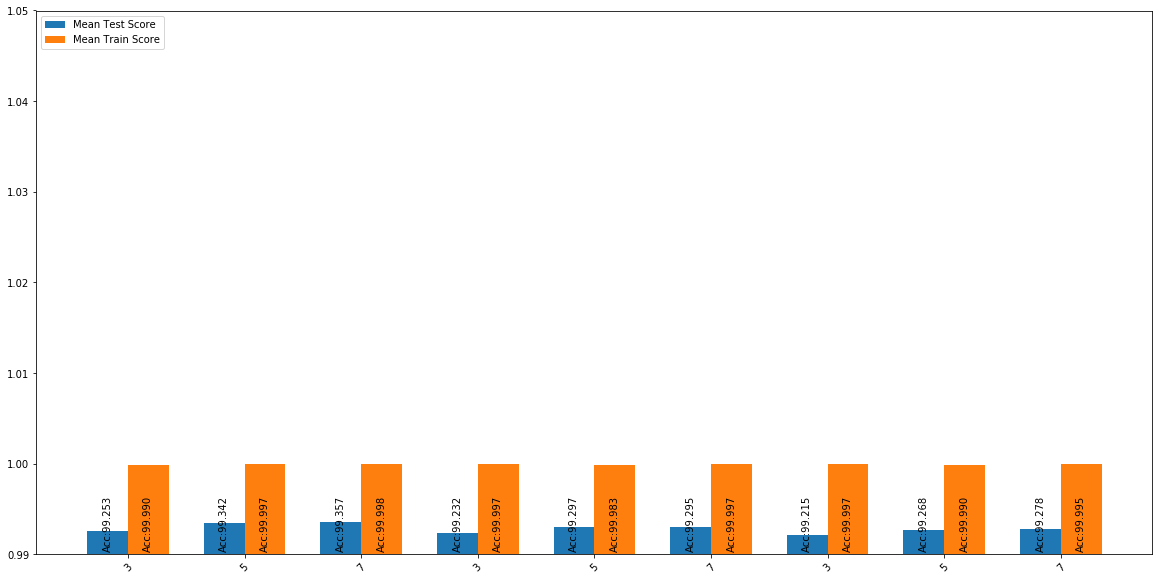

In [12]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(20,10))

ind= np.arange(len(params))
width= 0.35
print(len(params))

rects1 = ax.bar(ind - width/2, means_test, width, 
                label='Mean Test Score')
rects2 = ax.bar(ind + width/2, means_train, width, 
                label='Mean Train Score')

ax.set_xticks(ind)
ax.set_xticklabels([param['kernel_n'] for param in params], rotation=45)
batches= [param['batch_size'] for param in params]

i= 0
for rect in rects1:
    ax.annotate('Acc:{:.3f}'.format(means_test[i]*100), rotation=90,
                xy=(rect.get_x() + rect.get_width() / 2, 0.99),
                xytext=(0, 3),  # use 3 points offset
                textcoords="offset points",  # in both directions
                ha='center', va='bottom',
                horizontalalignment='center', verticalalignment='center_baseline')
    i+=1
i=0
for rect in rects2:
    ax.annotate('Acc:{:.3f}'.format(means_train[i]*100), rotation=90,
                xy=(rect.get_x() + rect.get_width() / 2, 0.99),
                xytext=(0, 3),  # use 3 points offset
                textcoords="offset points",  # in both directions
                ha='center', va='bottom')
    i+=1
ax.set_ylim(bottom=0.99)
ax.legend(loc= 'upper left')


I can see all my models above 99% mark also best accuracy is 99.347 which is also better than before


Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 71s 1ms/step - loss: 0.1233 - acc: 0.9626 - val_loss: 0.0346 - val_acc: 0.9878
Epoch 2/20
60000/60000 [==============================] - 60s 1ms/step - loss: 0.0575 - acc: 0.9820 - val_loss: 0.0194 - val_acc: 0.9941
Epoch 3/20
60000/60000 [==============================] - 60s 996us/step - loss: 0.0453 - acc: 0.9864 - val_loss: 0.0273 - val_acc: 0.9911
Epoch 4/20
60000/60000 [==============================] - 60s 996us/step - loss: 0.0376 - acc: 0.9889 - val_loss: 0.0232 - val_acc: 0.9922
Epoch 5/20
60000/60000 [==============================] - 60s 1ms/step - loss: 0.0319 - acc: 0.9903 - val_loss: 0.0228 - val_acc: 0.9927
Epoch 6/20
60000/60000 [==============================] - 60s 995us/step - loss: 0.0261 - acc: 0.9915 - val_loss: 0.0168 - val_acc: 0.9951
Epoch 7/20
60000/60000 [==============================] - 60s 1ms/step - loss: 0.0235 - acc: 0.9930 - val_loss: 0.0211 - v

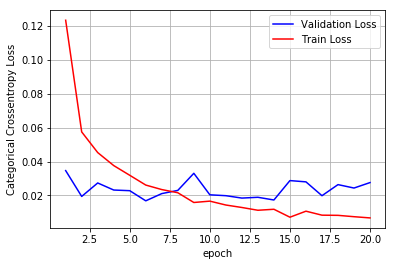

In [13]:
# Best model
model= conv_model_varying_kernel(5)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

history= model.fit(x_train, y_train,
          batch_size=32,
          epochs=20,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x = list(range(1,21))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, 1)

## Model 5 : Hyperparameter tuning with varying kernels with same number of filters and then increasing filter size, applying cross validation and comparing results

In [5]:
# Adding batch normalization to the model
def conv_model_varying_kernel_with_same_filter(kernel_n):
  Model_5 = Sequential()

  #Layer 1 [ReLU]
  Model_5.add(Conv2D(32, kernel_size=(kernel_n, kernel_n),
                  activation='relu',
                  input_shape=input_shape, padding='same'))
  Model_5.add(BatchNormalization())
  #Model_5.add(MaxPooling2D(pool_size=(2, 2), padding= 'same'))
  Model_5.add(Dropout(0.25))

  #Layer 2 [ReLU]
  Model_5.add(Conv2D(32, kernel_size=(kernel_n+2, kernel_n+2),
                  activation='relu',
                  padding='same'))
  Model_5.add(BatchNormalization())
  #Model_5.add(MaxPooling2D(pool_size=(2, 2), padding= 'same'))
  Model_5.add(Dropout(0.25))

  #Layer 3 [ReLU]
  Model_5.add(Conv2D(32, kernel_size=(kernel_n+4, kernel_n+4),
                  activation='relu',
                  padding='same'))
  Model_5.add(BatchNormalization())
  Model_5.add(MaxPooling2D(pool_size=(2, 2), padding= 'same'))
  Model_5.add(Dropout(0.25))


  #Layer 4 [ReLU]
  Model_5.add(Conv2D(64, kernel_size=(kernel_n, kernel_n),
                  activation='relu',
                  padding='same'))
  Model_5.add(BatchNormalization())
  #Model_5.add(MaxPooling2D(pool_size=(2, 2), padding= 'same'))
  Model_5.add(Dropout(0.25))

  #Layer 5 [ReLU]
  Model_5.add(Conv2D(64, kernel_size=(kernel_n+2, kernel_n+2),
                  activation='relu',
                  padding='same'))
  Model_5.add(BatchNormalization())
  #Model_5.add(MaxPooling2D(pool_size=(2, 2), padding= 'same'))
  Model_5.add(Dropout(0.25))

  #Layer 6 [ReLU]
  Model_5.add(Conv2D(64, kernel_size=(kernel_n+4, kernel_n+4),
                  activation='relu',
                  padding='same'))
  Model_5.add(BatchNormalization())
  Model_5.add(MaxPooling2D(pool_size=(2, 2), padding= 'same'))
  Model_5.add(Dropout(0.25))


  #Layer 7 [ReLU]
  Model_5.add(Conv2D(128, kernel_size=(kernel_n, kernel_n),
                  activation='relu',
                  padding='same'))
  Model_5.add(BatchNormalization())
  Model_5.add(Dropout(0.25))

  #Layer 8 [ReLU]
  Model_5.add(Conv2D(128, kernel_size=(kernel_n+2, kernel_n+2),
                  activation='relu',
                  padding='same'))
  Model_5.add(BatchNormalization())
  Model_5.add(Dropout(0.25))

  #Layer 9 [ReLU]
  Model_5.add(Conv2D(128, kernel_size=(kernel_n+4, kernel_n+4),
                  activation='relu',
                  padding='same'))
  Model_5.add(BatchNormalization())
  Model_5.add(MaxPooling2D(pool_size=(2, 2), padding= 'same'))
  Model_5.add(Dropout(0.25))

  #Layer 10 [ReLU]
  Model_5.add(Conv2D(256, kernel_size=(kernel_n, kernel_n),
                  activation='relu',
                  padding='same'))
  Model_5.add(BatchNormalization())
  Model_5.add(MaxPooling2D(pool_size=(2, 2), padding= 'same'))
  Model_5.add(Dropout(0.25))

  #Layer 11 [ReLU]
  Model_5.add(Conv2D(256, kernel_size=(kernel_n+2, kernel_n+2),
                  activation='relu',
                  padding='same'))
  Model_5.add(BatchNormalization())
  Model_5.add(Dropout(0.25))

  #Layer 12 [ReLU]
  Model_5.add(Conv2D(256, kernel_size=(kernel_n+4, kernel_n+4),
                  activation='relu',
                  padding='same'))
  Model_5.add(BatchNormalization())
  Model_5.add(MaxPooling2D(pool_size=(2, 2), padding= 'same'))
  Model_5.add(Dropout(0.25))
  
  Model_5.add(Flatten())

  #Layer 13 [Softmax]
  Model_5.add(Dense(10, activation='softmax'))

  Model_5.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.Adadelta(),
                metrics=['accuracy'])
  
  return Model_5


from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, ShuffleSplit

model = KerasClassifier(build_fn=conv_model_varying_kernel_with_same_filter, epochs=20, verbose=0)

batch = [32, 64]
param_grid = dict(batch_size=batch,\
                  kernel_n= [3, 5]
                  )

grid = GridSearchCV(estimator= model, param_grid= param_grid, cv= 2, return_train_score= True, verbose= 10)
grid_result_varyingKernelFixedFilters= grid.fit(x_train, y_train)


Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] batch_size=32, kernel_n=3 .......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  batch_size=32, kernel_n=3, score=(train=0.999, test=0.993), total=23.9min
[CV] batch_size=32, kernel_n=3 .......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 24.2min remaining:    0.0s


[CV]  batch_size=32, kernel_n=3, score=(train=0.999, test=0.993), total=24.4min
[CV] batch_size=32, kernel_n=5 .......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 48.8min remaining:    0.0s


[CV]  batch_size=32, kernel_n=5, score=(train=0.999, test=0.993), total=28.8min
[CV] batch_size=32, kernel_n=5 .......................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 78.0min remaining:    0.0s


[CV]  batch_size=32, kernel_n=5, score=(train=0.999, test=0.993), total=29.0min
[CV] batch_size=64, kernel_n=3 .......................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 107.3min remaining:    0.0s


[CV]  batch_size=64, kernel_n=3, score=(train=0.999, test=0.993), total=16.2min
[CV] batch_size=64, kernel_n=3 .......................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 123.7min remaining:    0.0s


[CV]  batch_size=64, kernel_n=3, score=(train=0.999, test=0.993), total=16.2min
[CV] batch_size=64, kernel_n=5 .......................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 140.1min remaining:    0.0s


[CV]  batch_size=64, kernel_n=5, score=(train=0.998, test=0.991), total=19.4min
[CV] batch_size=64, kernel_n=5 .......................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 159.8min remaining:    0.0s


[CV]  batch_size=64, kernel_n=5, score=(train=0.999, test=0.992), total=19.5min


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 179.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 179.5min finished


In [6]:
print("Best: %f using %s" % (grid_result_varyingKernelFixedFilters.best_score_, grid_result_varyingKernelFixedFilters.best_params_))
print("Best estimator: ", grid_result_varyingKernelFixedFilters.best_estimator_)

means_test = grid_result_varyingKernelFixedFilters.cv_results_['mean_test_score']
means_train = grid_result_varyingKernelFixedFilters.cv_results_['mean_train_score']
stds_test = grid_result_varyingKernelFixedFilters.cv_results_['std_test_score']
stds_train = grid_result_varyingKernelFixedFilters.cv_results_['std_train_score']
params = grid_result_varyingKernelFixedFilters.cv_results_['params']

for mean, mean_train, stdev, param in zip(means_test, means_train, stds_test, params):
    print("%f %f (%f) with: %r" % (mean, mean_train, stdev, param))

Best: 0.993317 using {'batch_size': 32, 'kernel_n': 3}
Best estimator:  <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f5aa98f12e8>
0.993317 0.999083 (0.000017) with: {'batch_size': 32, 'kernel_n': 3}
0.992967 0.999100 (0.000200) with: {'batch_size': 32, 'kernel_n': 5}
0.992667 0.998983 (0.000167) with: {'batch_size': 64, 'kernel_n': 3}
0.991917 0.998467 (0.000483) with: {'batch_size': 64, 'kernel_n': 5}


In [0]:
import pickle
with open('grid_result_varyingKernelFixedFilters.pickle', 'wb') as handle:
    pickle.dump(grid_result_varyingKernelFixedFilters.cv_results_, handle, protocol=pickle.HIGHEST_PROTOCOL)
!cp grid_result_varyingKernelFixedFilters.pickle drive/My\ Drive/CNN_models/

4


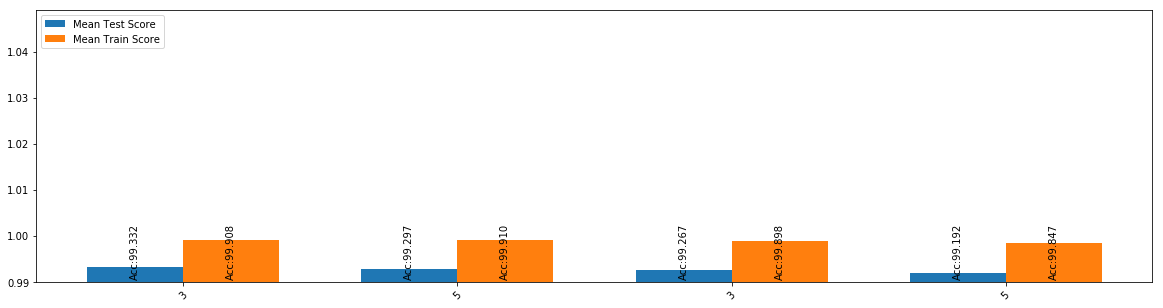

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,5))

ind= np.arange(len(params))
width= 0.35
print(len(params))

rects1 = ax.bar(ind - width/2, means_test, width, 
                label='Mean Test Score')
rects2 = ax.bar(ind + width/2, means_train, width, 
                label='Mean Train Score')

ax.set_xticks(ind)
ax.set_xticklabels([param['kernel_n'] for param in params], rotation=45)
batches= [param['batch_size'] for param in params]

i= 0
for rect in rects1:
    ax.annotate('Acc:{:.3f}'.format(means_test[i]*100), rotation=90,
                xy=(rect.get_x() + rect.get_width() / 2, 0.99),
                xytext=(0, 3),  # use 3 points offset
                textcoords="offset points",  # in both directions
                ha='center', va='bottom',
                horizontalalignment='center', verticalalignment='center_baseline')
    i+=1
i=0
for rect in rects2:
    ax.annotate('Acc:{:.3f}'.format(means_train[i]*100), rotation=90,
                xy=(rect.get_x() + rect.get_width() / 2, 0.99),
                xytext=(0, 3),  # use 3 points offset
                textcoords="offset points",  # in both directions
                ha='center', va='bottom')
    i+=1
ax.set_ylim(bottom=0.99)
ax.legend(loc= 'upper left')

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 160s 3ms/step - loss: 0.2779 - acc: 0.9179 - val_loss: 0.0789 - val_acc: 0.9791
Epoch 2/20
60000/60000 [==============================] - 147s 2ms/step - loss: 0.0858 - acc: 0.9768 - val_loss: 0.0489 - val_acc: 0.9862
Epoch 3/20
60000/60000 [==============================] - 147s 2ms/step - loss: 0.0682 - acc: 0.9808 - val_loss: 0.0345 - val_acc: 0.9903
Epoch 4/20
60000/60000 [==============================] - 147s 2ms/step - loss: 0.0594 - acc: 0.9838 - val_loss: 0.0303 - val_acc: 0.9913
Epoch 5/20
60000/60000 [==============================] - 147s 2ms/step - loss: 0.0495 - acc: 0.9859 - val_loss: 0.0374 - val_acc: 0.9903
Epoch 6/20
60000/60000 [==============================] - 147s 2ms/step - loss: 0.0425 - acc: 0.9879 - val_loss: 0.0314 - val_acc: 0.9916
Epoch 7/20
60000/60000 [==============================] - 147s 2ms/step - loss: 0.0389 - acc: 0.9889 - val_loss: 0.0425 - 

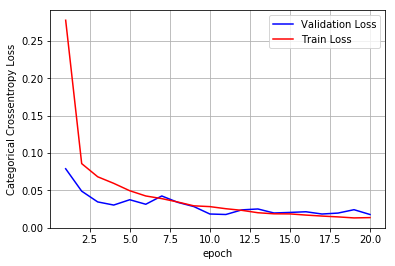

In [22]:
# best model

model= conv_model_varying_kernel_with_same_filter(3)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

history= model.fit(x_train, y_train,
          batch_size=32,
          epochs=20,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x = list(range(1,21))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, 1)

{'batch_size': 32, 'kernel_n': 3}


## Comparision

In [7]:
from prettytable import PrettyTable
print('Accuracy comparision')

x= PrettyTable(['Model', 'Batch_size', 'Validation Score', 'Observation'])
x.add_row(['Model 1', '64', '99.33', 'This is the simplest model with same kernel values, best kernel being (7x7)'])
x.add_row(['Model 2', '32', '99.44', 'This is a 3 layer model with same kernel size, best hyperparameter is (7x7) kernel size and batch size= 32'])
x.add_row(['Model 3', '64', '99.34', 'This is a 3 layer model followed by a dense layer,we have varied kernel size with layers in this model, this model is also starting to overfit'])
x.add_row(['Model 4', '32', '99.35', 'The model is starting to overfit looking at loss vs epochs curve'])
x.add_row(['Model 5', '32', '99.5', 'This seems like the best model among all, I have mixed together kernels with layers and dropouts, also the model is not overfitting'])
x.align= 'l'
print(x)

Accuracy comparision
+---------+------------+------------------+------------------------------------------------------------------------------------------------------------------------------------------------+
| Model   | Batch_size | Validation Score | Observation                                                                                                                                    |
+---------+------------+------------------+------------------------------------------------------------------------------------------------------------------------------------------------+
| Model 1 | 64         | 99.33            | This is the simplest model with same kernel values, best kernel being (7x7)                                                                    |
| Model 2 | 32         | 99.44            | This is a 3 layer model with same kernel size, best hyperparameter is (7x7) kernel size and batch size= 32                                     |
| Model 3 | 64         | 99.34    